# Parcels Experiment:<br><br>Spawning larvae at the Iceland-Faroe ridge

_(Based on an experiment originally designed by Christina Schmidt.)_

_(Runs on GEOMAR Jupyter Server at https://schulung3.geomar.de/user/workshop007/lab)_

## To do

- Check/ask how OceanParcels deals with partial cells, if it does.
- Shouldn't need to check all of T,u,v to find if particles are in the bed, but I do.
- Check/ask about dates on monthly mean fields.

## Technical preamble

In [1]:
%matplotlib inline

from parcels import (
    AdvectionRK4_3D,
    ErrorCode,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable
)

# from operator import attrgetter
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
# import xarray as xr


## Experiment settings (user input)

See [010_Parcels_Release.ipynb](010_Parcels_Release.ipynb) for details on the position of the particles on the ridge.

In [2]:

# Line along Iceland-Faroe ridge

west_lat = 65.0
east_lat = 62.2
west_lon = -14.0
east_lon = -7

min_release_depth = 0
max_release_depth = 700

# release numbers
create_number_particles = 10000  # about half will not be ocean points, then take first 2000.
use_number_particles = 4000  # about half will not be ocean points, then take first 2000.
# number_particles = 500  # about half will not be ocean points, then take first 2000.
# release_time_in_days = 5

# experiment duration etc
runtime_in_days = 2
dt_in_minutes = 10
# repeatdt = timedelta(days=3)

# set base release date and time
t_0 = t = datetime(2014,1,16,12,0,0)  # using monthly mean fields. Check dates.
t_start = datetime(2016,12,16,12,0,0)

# loop over single year of model data
time_loop_period = timedelta(days=365)

# particle positions are stored every x hours 
outputdt_in_hours = 24

# location of input data
data_path = Path('/data/iAtlantic/data/')
experiment_name = 'VIKING20X.L46-KKG36107B' 
data_resolution = '1m'

# location of mask data
mask_path = Path('/data/iAtlantic/mask/')
mesh_mask_filename = '1_mesh_mask.nc_notime_depthw'

# names of files to load 
fname_U = f'1_{experiment_name}_{data_resolution}_201[4-7]*_grid_U.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_201[4-7]*_grid_V.nc'
fname_T = f'1_{experiment_name}_{data_resolution}_201[4-7]*_grid_T.nc'
fname_W = f'1_{experiment_name}_{data_resolution}_201[4-7]*_grid_W.nc_repaire_depthw_time'

print(fname_U)

# location of output data
outpath = Path('./')
# output_filename = 'Parcels_IFFForwards_1m_June2016_2000.nc'
output_filename = 'test_forward_IFR_dec.nc'


# select subdomain (to decrease needed resources)
sd_i1, sd_i2 = 1400, 2404  # western/eastern limit (indices not coordinates)
sd_j1, sd_j2 = 1800, 2499  # southern/northern limit (indices not coordinates)
sd_z1, sd_z2 = 0, 46

# how to initialize the random number generator
RNG_seed = 123

1_VIKING20X.L46-KKG36107B_1m_201[4-7]*_grid_U.nc


## Construct input / output paths etc.

In [3]:
mesh_mask = mask_path / experiment_name / mesh_mask_filename
outfile = outpath / output_filename

## Load input datasets

In [4]:
def fieldset_defintions(
    list_of_filenames_U, list_of_filenames_V,
    list_of_filenames_W, list_of_filenames_T,
    mesh_mask
):
    
    filenames = {'U': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_U},
                 'V': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_V},
                 'W': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_W[0],
                       'data': list_of_filenames_W},
                 'T': {'lon': (mesh_mask),
                       'lat': (mesh_mask),
                       'depth': list_of_filenames_T[0],
                       'data': list_of_filenames_T}
                }
    
    variables = {'U': 'vozocrtx',
                 'V': 'vomecrty',
                 'W': 'vovecrtz',
                 'T': 'votemper'
                }
        
    dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw',
                        'time': 'time_counter'},  # needs to be on f-nodes
                  'T': {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht',
                        'time': 'time_counter'},  # needs to be on t-nodes
                 }
    
    indices = {
        'U': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'V': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat': range(sd_j1, sd_j2)},
        'W': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2), 'lat':range(sd_j1, sd_j2)},
        'T': {'depth': range(sd_z1, sd_z2), 'lon': range(sd_i1, sd_i2)}, 'lat':range(sd_j1, sd_j2)
    }    
    
    field_chunksizes = {'U': {'lon': 'auto', 'lat': 'auto', 'depth': 'auto',
                        'time': 5},  # needs to be on f-nodes
                  'V': {'lon': 'auto', 'lat': 'auto', 'depth': 'auto',
                        'time': 5},  # needs to be on f-nodes
                  'W': {'lon': 'auto', 'lat': 'auto', 'depth': 'auto',
                        'time': 5},  # needs to be on f-nodes
                  'T': {'lon': 'auto', 'lat': 'auto', 'depth': 'auto',
                        'time': 5},  # needs to be on t-nodes
                 }

    return FieldSet.from_nemo(
        filenames, variables, dimensions, indices=indices,
        field_chunksize=False,
#         field_chunksize=field_chunksizes,
        mesh='spherical',
        tracer_interp_method='cgrid_tracer'
#         ,time_periodic=time_loop_period
#         ,allow_time_extrapolation=True
    )

In [5]:
def create_fieldset(
    data_path=data_path, experiment_name=experiment_name,
    fname_U=fname_U, fname_V=fname_V, fname_W=fname_W, fname_T=fname_T,
    mesh_mask = mesh_mask
):
    
    files_U = list(sorted((data_path / experiment_name).glob(fname_U)))
    files_V = list(sorted((data_path / experiment_name).glob(fname_V)))
    files_W = list(sorted((data_path / experiment_name).glob(fname_W)))
    files_T = list(sorted((data_path / experiment_name).glob(fname_T)))
    
    print(files_U)
    
    fieldset = fieldset_defintions(
        files_U, files_V,
        files_W, files_T, mesh_mask)

    return fieldset

In [6]:
fieldset = create_fieldset()

[PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/1_VIKING20X.L46-KKG36107B_1m_20140101_20141231_grid_U.nc'), PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/1_VIKING20X.L46-KKG36107B_1m_20150101_20151231_grid_U.nc'), PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/1_VIKING20X.L46-KKG36107B_1m_20160101_20161231_grid_U.nc'), PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/1_VIKING20X.L46-KKG36107B_1m_20170101_20171231_grid_U.nc')]


## Create Virtual Particles

In [7]:
class SampleParticle(JITParticle):
    """Add variables to the standard particle class.
    
    Particles will sample temperature and track the age of the particle.
    Particles also have a flag `alive` that is 1 if the particle is alive and 0 otherwise.
    Furthermore, we have a `speed_param` that scales the velocity with which particles can
    swim towards the surface.

    Note that we don't initialize temp from the actual data.
    This speeds up particle creation, but might render initial data point less useful.
    """
    temp = Variable('temp', dtype=np.float32, initial=-100)
    uvel = Variable('uvel', dtype=np.float32, initial=0)
    vvel = Variable('vvel', dtype=np.float32, initial=0)
    wvel = Variable('wvel', dtype=np.float32, initial=0)
#     alive = Variable('alive', dtype=np.int32, initial=1)
#     speed_param = Variable('speed_param', dtype=np.float32, initial=1)
#     age = Variable('age', dtype=np.int32, initial=0, to_write=True)

## Create a set of particles with random initial positions

We seed the RNG to be reproducible (and to be able to quickly create a second equivalent experiment with differently chosen compatible initial positions), and create arrays of random starting times, lats, lons, depths, and speed parameters (see kernel definitions below for details).

Initially create points on 'rectangle'. Land points are removed later.

In [8]:
np.random.seed(RNG_seed)

# define time of release for each particle relative to t0
# can start each particle at a different time if required
# here all start at time t_start.

time = np.zeros(create_number_particles)

time += (t_start - t_0).total_seconds()

# start along a line from west to east

lon = np.random.uniform(
    low=west_lon, high = east_lon,
    size=time.shape
)

lat = west_lat + ((lon - west_lon) * (east_lat - west_lat)/ (east_lon - west_lon))

# at depths from surface to max_release_depth

depth = np.random.uniform(
    low=min_release_depth, high=max_release_depth,
    size=time.shape
)

In [9]:
%%time

pset = ParticleSet(
    fieldset=fieldset,
    pclass=SampleParticle,
    lat=lat,
    lon=lon,
#     speed_param=speed_param,
    depth=depth,
    time=time
#    repeatdt = repeatdt
)


CPU times: user 1.81 s, sys: 5.75 ms, total: 1.82 s
Wall time: 1.82 s


In [10]:
print(f"Created {len(pset)} particles.")
# display(pset[:5])
# display(pset[-5:])

Created 10000 particles.


## Compose custom kernel

We'll create two additional kernels:
- One Kernel adds active vertical movement.
- One Kernel adds a temperature sensitivity.

Then, we combine the builtin `AdvectionRK4_3D` kernel with these additional kernels.

In [11]:
def movement(particle, fieldset, time):
    '''Add active vertical movement.
    
    Upward movement for 5 days depending on the age of the larvae,
    
    * Larvae get faster linearly.
    * Maximum speed that can be reached is about 0.2 cm/s at 5 days of age.
    * Active movement differs between the larvae (scaled by individual speed parameter).
    * Raising stops if 100m depth is reached.
    
    '''
    particle.age += particle.dt
    
    if (particle.age < 5 * 86400) and (particle.depth > 100):
        vel = -4e-8 * particle.age * particle.speed_param # in m/s
        particle.depth += vel * particle.dt

In [12]:
def velocity_sampling(particle, fieldset, time):
    '''Sample velocity.'''
    
    (particle.uvel,particle.vvel,particle.wvel) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
    

In [13]:
def temperature_sampling(particle, fieldset, time):
    '''Sample temperature.'''
    
    particle.temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]

In [14]:
def temperature_sensitivity(particle, fieldset, time):
    '''Change status of adult larvae if ambient temperature is too low.
    
    Larvae that are older than 5 days die in water temperatures below 4°C.
    
    Larvae that are dead will stay dead if temperature increases above 4°C.
    '''
    
    temp = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    
    if ( (temp < 4.0) and (particle.age > 5.0 * 86400) ) or (particle.alive == 0):
        particle.alive = 0

In [15]:
custom_kernel = (
    pset.Kernel(AdvectionRK4_3D)
#     + pset.Kernel(temperature_sensitivity)
     + pset.Kernel(temperature_sampling)
     + pset.Kernel(velocity_sampling)
#     + pset.Kernel(movement)
)

## Be able to handle errors during integration

We have restricted our domain so in principle, particles could reach undefined positions.
In that case, we want to just delete the particle (without forgetting its history).

In [16]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()


recovery_cases = {
    ErrorCode.ErrorOutOfBounds: DeleteParticle
}

## Run with runtime=0 to initialise fields

In [17]:
pset.execute(
    custom_kernel,
     runtime=0,    
     dt=timedelta(minutes=0),      
#      output_file=outputfile,
     recovery=recovery_cases
)

INFO: Compiled SampleParticleAdvectionRK4_3Dtemperature_samplingvelocity_sampling ==> /tmp/parcels-1013/1ebc201d3b1f3898d80e75f70484a50f_0.so


## Trim unwanted points from ParticleSet

Use initialised fields to remove land points (test `temp * uvel * vvel == 0.0`) and select first `use_number_particles` particles

In [18]:
x = np.array([p.temp for p in pset])
y = np.array([p.uvel for p in pset])
z = np.array([p.vvel for p in pset])
pset.remove(np.argwhere(x * y * z == 0).flatten())
print(len(pset))
pset.remove(range(use_number_particles,len(pset)))
print(len(pset))

4694
4000


## Plot release positions

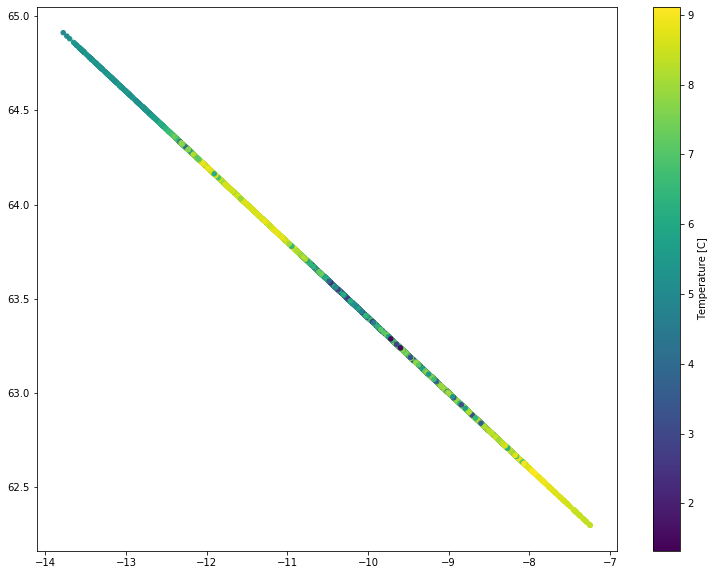

In [19]:
plt.figure(figsize=(13,10))

plt.scatter(
    [p.lon for p in pset],
    [p.lat for p in pset],
    20,
    [p.temp for p in pset]
)
plt.colorbar(label = "Temperature [C]");

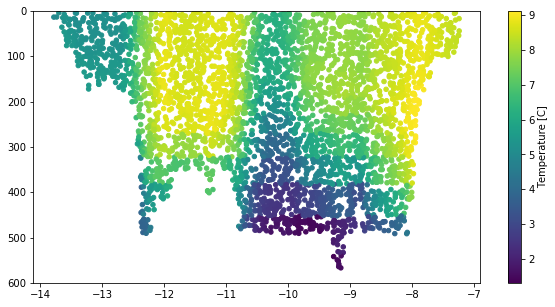

In [20]:
plt.figure(figsize=(10,5))

plt.scatter(
    [p.lon for p in pset],
    [p.depth for p in pset],
    20,
    [p.temp for p in pset]
)
plt.ylim(600,0)
plt.colorbar(label = "Temperature [C]");


This is showing steps in topography even though it uses the field values to choose particles. This raises some questions over how OceanParcels deals with shaved cells at bed. I think maybe some of the nearbed particles never move...

## Prepare output

We define an output file and specify the desired output frequency.

In [21]:
print(output_filename)

outputfile = pset.ParticleFile(
    name=output_filename,
    outputdt=timedelta(hours=outputdt_in_hours)
)

test_forward_IFR_dec.nc


## Execute the experiment

We'll evolve particles, log their positions and variables to the output buffer and finally export the output to a  the file.

### Run the experiment

In [22]:
pset.execute(
    custom_kernel,
     runtime=timedelta(days=runtime_in_days),    
     dt=timedelta(minutes=dt_in_minutes),      
     output_file=outputfile,
     recovery=recovery_cases
)

In [23]:
outputfile.export()

In [24]:
# conda list


In [25]:
# pip list
